In [ ]:
#!apt-get install net-tools # To see my interface
!apt-get install tcpdump # To capture packages
#!apt-get install dnsutils
!apt-get install curl # To create traffic to websites
!apt-get install tshark #

In [2]:
!pip install pyshark
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00


In [20]:
import pyshark
import os
import pandas as pd
import nest_asyncio
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/NMDA/HW2"

Mounted at /content/drive


In [4]:
! mkdir captures

In [24]:
! rm captures/*
! rm data/*
! rm *.zip
! rm *.csv

In [25]:
import urllib
import json
def get_information(ip):
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']
        return country, city, latitude, longitude

api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude

('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

In [26]:
! bash capture.sh captures capture \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
295 packets captured1411 packets captured

295 packets received by filter1411 packets received by filter

0 packets dropped by kernel0 packe

In [27]:
import zipfile
directory_to_zip = "/content/captures"
zip_file_name = "captures.zip"

# Create a zipfile object in write mode
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files and folders within the directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

In [28]:
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initialize CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto':[], 'ip.len': [], 'frame.time': []}

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)
        # Extract label from filename
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Read the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
            address_a = packet.ip.src
            address_b = packet.ip.dst
            tcp_srcport = packet.tcp.srcport
            tcp_dstport = packet.tcp.dstport
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)
            ip_len = packet.ip.len
            frame_time = packet.sniff_time.strftime("%Y-%m-%d %H:%M:%S.%f")

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)

# Create DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

# Display the DataFrame
print(df)


              ip.src         ip.dst tcp.srcport tcp.dstport  bytes  packets  \
0        172.28.0.12    96.7.140.92       35122         443     74        1   
1        96.7.140.92    172.28.0.12         443       35122     74        1   
2        172.28.0.12    96.7.140.92       35122         443     66        1   
3        172.28.0.12    96.7.140.92       35122         443    583        1   
4        96.7.140.92    172.28.0.12         443       35122     66        1   
...              ...            ...         ...         ...    ...      ...   
17848  23.56.230.240    172.28.0.12         443       57074     66        1   
17849  23.56.230.240    172.28.0.12         443       57074     97        1   
17850    172.28.0.12  23.56.230.240       57074         443     54        1   
17851  23.56.230.240    172.28.0.12         443       57074     66        1   
17852    172.28.0.12  23.56.230.240       57074         443     54        1   

                           start  duration       la

In [ ]:
#much easier than looping over all packets!
#df_tcp = df[df["ip.proto"]=='6']
#df_flows_tcp = df_tcp.groupby(["address_a","address_b","port_a","port_b"])

#for flow, df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
 # print(flow)
 # display(df_flow)

In [29]:
! mkdir data
df.to_csv('data/df_flows_tcp.csv', index=False)


mkdir: cannot create directory ‘data’: File exists


In [30]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='10'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

#df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features = extract_features(flow,df_flow)
  display(flow)
  display(flow_features)




('172.28.0.12', '18.154.101.124', '52686', '443')

{'direction': 'downlink',
 'num_packets': 52,
 'total_bytes': 3542.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 68.11538461538461,
 'std_pkt_size': 72.66891177845487,
 'min_iat': 1e-05,
 'max_iat': 0.332121,
 'mean_iat': 0.013126549019607844,
 'std_iat': 0.050105438737252345,
 'dur': 0.6694540000000001,
 'dport': '443',
 'sport': '52686'}

('172.28.0.12', '18.154.101.124', '52692', '443')

{'direction': 'downlink',
 'num_packets': 61,
 'total_bytes': 4010.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.73770491803279,
 'std_pkt_size': 67.24480194021055,
 'min_iat': 8e-06,
 'max_iat': 0.055097,
 'mean_iat': 0.0023992333333333333,
 'std_iat': 0.007365003587435504,
 'dur': 0.143954,
 'dport': '443',
 'sport': '52692'}

('172.28.0.12', '18.154.101.124', '52698', '443')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 3854.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.44827586206897,
 'std_pkt_size': 68.91596011359563,
 'min_iat': 1e-05,
 'max_iat': 0.0938,
 'mean_iat': 0.0032077894736842103,
 'std_iat': 0.012474077307327101,
 'dur': 0.18284399999999998,
 'dport': '443',
 'sport': '52698'}

('172.28.0.12', '18.154.101.124', '52714', '443')

{'direction': 'downlink',
 'num_packets': 60,
 'total_bytes': 3958.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.96666666666667,
 'std_pkt_size': 67.78829624164214,
 'min_iat': 1.1e-05,
 'max_iat': 0.057102,
 'mean_iat': 0.0026111525423728812,
 'std_iat': 0.007803461992124811,
 'dur': 0.154058,
 'dport': '443',
 'sport': '52714'}

('172.28.0.12', '18.154.101.124', '52730', '443')

{'direction': 'downlink',
 'num_packets': 62,
 'total_bytes': 4062.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.51612903225806,
 'std_pkt_size': 66.71415460091077,
 'min_iat': 9e-06,
 'max_iat': 0.054921,
 'mean_iat': 0.0024003770491803273,
 'std_iat': 0.007319159373780421,
 'dur': 0.14642299999999997,
 'dport': '443',
 'sport': '52730'}

('172.28.0.12', '18.154.101.124', '55390', '443')

{'direction': 'downlink',
 'num_packets': 55,
 'total_bytes': 3698.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 67.23636363636363,
 'std_pkt_size': 70.71800117534215,
 'min_iat': 1.3e-05,
 'max_iat': 0.066443,
 'mean_iat': 0.0029135370370370365,
 'std_iat': 0.00924576961645104,
 'dur': 0.15733099999999997,
 'dport': '443',
 'sport': '55390'}

('172.28.0.12', '18.154.101.124', '55394', '443')

{'direction': 'downlink',
 'num_packets': 57,
 'total_bytes': 3802.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.70175438596492,
 'std_pkt_size': 69.50127565948513,
 'min_iat': 1.2e-05,
 'max_iat': 0.055571,
 'mean_iat': 0.002488875,
 'std_iat': 0.007640301243614797,
 'dur': 0.139377,
 'dport': '443',
 'sport': '55394'}

('172.28.0.12', '18.154.101.124', '55396', '443')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 3854.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.44827586206897,
 'std_pkt_size': 68.91596011359563,
 'min_iat': 7e-06,
 'max_iat': 0.055206,
 'mean_iat': 0.0025467192982456133,
 'std_iat': 0.007570084309670122,
 'dur': 0.14516299999999996,
 'dport': '443',
 'sport': '55396'}

('172.28.0.12', '18.154.101.124', '55408', '443')

{'direction': 'downlink',
 'num_packets': 59,
 'total_bytes': 3906.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.20338983050847,
 'std_pkt_size': 68.34516345449234,
 'min_iat': 6e-06,
 'max_iat': 0.054619,
 'mean_iat': 0.0025232931034482762,
 'std_iat': 0.007456323730850871,
 'dur': 0.146351,
 'dport': '443',
 'sport': '55408'}

('172.28.0.12', '18.154.101.124', '55416', '443')

{'direction': 'downlink',
 'num_packets': 59,
 'total_bytes': 3906.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.20338983050847,
 'std_pkt_size': 68.34516345449234,
 'min_iat': 1.5e-05,
 'max_iat': 0.056054,
 'mean_iat': 0.0024189482758620695,
 'std_iat': 0.007571189979060892,
 'dur': 0.14029900000000003,
 'dport': '443',
 'sport': '55416'}

('172.28.0.12', '184.24.57.145', '35370', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 7e-06,
 'max_iat': 0.064488,
 'mean_iat': 0.018171714285714288,
 'std_iat': 0.02189105275055251,
 'dur': 0.254404,
 'dport': '443',
 'sport': '35370'}

('172.28.0.12', '184.24.57.145', '42506', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 7e-06,
 'max_iat': 0.054167,
 'mean_iat': 0.019460384615384616,
 'std_iat': 0.021100504455022165,
 'dur': 0.252985,
 'dport': '443',
 'sport': '42506'}

('172.28.0.12', '184.24.57.145', '42522', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 1.1e-05,
 'max_iat': 0.065153,
 'mean_iat': 0.022894692307692303,
 'std_iat': 0.025285349880199454,
 'dur': 0.2976309999999999,
 'dport': '443',
 'sport': '42522'}

('172.28.0.12', '184.24.57.145', '42528', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 8e-06,
 'max_iat': 0.054287,
 'mean_iat': 0.019335000000000005,
 'std_iat': 0.02079028321917076,
 'dur': 0.25135500000000005,
 'dport': '443',
 'sport': '42528'}

('172.28.0.12', '184.24.57.145', '42540', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 8e-06,
 'max_iat': 0.092611,
 'mean_iat': 0.02061228571428571,
 'std_iat': 0.02726842826541226,
 'dur': 0.28857199999999994,
 'dport': '443',
 'sport': '42540'}

('172.28.0.12', '184.24.57.145', '42546', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 6e-06,
 'max_iat': 0.086745,
 'mean_iat': 0.019708714285714284,
 'std_iat': 0.025869514685550907,
 'dur': 0.275922,
 'dport': '443',
 'sport': '42546'}

('172.28.0.12', '184.24.57.145', '42554', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 6e-06,
 'max_iat': 0.055785,
 'mean_iat': 0.017560785714285713,
 'std_iat': 0.019896331088839054,
 'dur': 0.245851,
 'dport': '443',
 'sport': '42554'}

('172.28.0.12', '184.24.57.145', '42556', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 8e-06,
 'max_iat': 0.054769,
 'mean_iat': 0.016961214285714284,
 'std_iat': 0.019758962220407034,
 'dur': 0.237457,
 'dport': '443',
 'sport': '42556'}

('172.28.0.12', '184.24.57.145', '42564', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 7e-06,
 'max_iat': 0.055105,
 'mean_iat': 0.020706538461538464,
 'std_iat': 0.022501565947786035,
 'dur': 0.269185,
 'dport': '443',
 'sport': '42564'}

('172.28.0.12', '184.24.57.145', '59368', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 7e-06,
 'max_iat': 0.055641,
 'mean_iat': 0.017761285714285716,
 'std_iat': 0.02068868002789698,
 'dur': 0.24865800000000002,
 'dport': '443',
 'sport': '59368'}

('172.28.0.12', '192.0.66.32', '49078', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 8e-06,
 'max_iat': 0.054003,
 'mean_iat': 0.008676357142857144,
 'std_iat': 0.01487395400644073,
 'dur': 0.12146900000000001,
 'dport': '443',
 'sport': '49078'}

('172.28.0.12', '192.0.66.32', '49094', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 8e-06,
 'max_iat': 0.055301,
 'mean_iat': 0.008747785714285713,
 'std_iat': 0.015198084956176711,
 'dur': 0.122469,
 'dport': '443',
 'sport': '49094'}

('172.28.0.12', '192.0.66.32', '49108', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1544.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 90.82352941176471,
 'std_pkt_size': 122.80586065723698,
 'min_iat': 7e-06,
 'max_iat': 0.055448,
 'mean_iat': 0.007679937499999999,
 'std_iat': 0.014500816645824928,
 'dur': 0.12287899999999999,
 'dport': '443',
 'sport': '49108'}

('172.28.0.12', '192.0.66.32', '49116', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 9e-06,
 'max_iat': 0.091587,
 'mean_iat': 0.0104824,
 'std_iat': 0.02339240869781721,
 'dur': 0.157236,
 'dport': '443',
 'sport': '49116'}

('172.28.0.12', '192.0.66.32', '49128', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1544.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 90.82352941176471,
 'std_pkt_size': 122.80586065723698,
 'min_iat': 4e-06,
 'max_iat': 0.055827,
 'mean_iat': 0.00769825,
 'std_iat': 0.014579645823315918,
 'dur': 0.123172,
 'dport': '443',
 'sport': '49128'}

('172.28.0.12', '192.0.66.32', '49138', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 4e-06,
 'max_iat': 0.054966,
 'mean_iat': 0.008450142857142857,
 'std_iat': 0.01496908227934212,
 'dur': 0.118302,
 'dport': '443',
 'sport': '49138'}

('172.28.0.12', '192.0.66.32', '49152', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 7e-06,
 'max_iat': 0.054438,
 'mean_iat': 0.008081266666666665,
 'std_iat': 0.014629811777261364,
 'dur': 0.12121899999999998,
 'dport': '443',
 'sport': '49152'}

('172.28.0.12', '192.0.66.32', '58918', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 1.7e-05,
 'max_iat': 0.055322,
 'mean_iat': 0.008145333333333333,
 'std_iat': 0.014797848220345447,
 'dur': 0.12218,
 'dport': '443',
 'sport': '58918'}

('172.28.0.12', '192.0.66.32', '58932', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 4e-06,
 'max_iat': 0.053851,
 'mean_iat': 0.007898933333333334,
 'std_iat': 0.014400822622667215,
 'dur': 0.118484,
 'dport': '443',
 'sport': '58932'}

('172.28.0.12', '192.0.66.32', '58946', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 7e-06,
 'max_iat': 0.059562,
 'mean_iat': 0.008342533333333336,
 'std_iat': 0.015601577840840633,
 'dur': 0.12513800000000003,
 'dport': '443',
 'sport': '58946'}

('172.28.0.12', '23.222.170.6', '36270', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8881.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.29677419354839,
 'std_pkt_size': 42.76212886247921,
 'min_iat': 5e-06,
 'max_iat': 10.01324,
 'mean_iat': 0.0666811038961039,
 'std_iat': 0.8067720368067567,
 'dur': 10.26889,
 'dport': '443',
 'sport': '36270'}

('172.28.0.12', '23.222.170.6', '37542', '443')

{'direction': 'downlink',
 'num_packets': 183,
 'total_bytes': 10385.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.74863387978142,
 'std_pkt_size': 39.391137869182636,
 'min_iat': 4e-06,
 'max_iat': 10.033796,
 'mean_iat': 0.05648436813186813,
 'std_iat': 0.7436683662842021,
 'dur': 10.280154999999999,
 'dport': '443',
 'sport': '37542'}

('172.28.0.12', '23.222.170.6', '38378', '443')

{'direction': 'downlink',
 'num_packets': 204,
 'total_bytes': 11537.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.55392156862745,
 'std_pkt_size': 37.300695780746636,
 'min_iat': 4e-06,
 'max_iat': 8.11443,
 'mean_iat': 0.04285578325123152,
 'std_iat': 0.5694144186747514,
 'dur': 8.699724,
 'dport': '443',
 'sport': '38378'}

('172.28.0.12', '23.222.170.6', '45392', '443')

{'direction': 'downlink',
 'num_packets': 191,
 'total_bytes': 10777.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.424083769633505,
 'std_pkt_size': 38.52044222942982,
 'min_iat': 5e-06,
 'max_iat': 10.047416,
 'mean_iat': 0.05466016842105261,
 'std_iat': 0.7288161522877906,
 'dur': 10.385431999999996,
 'dport': '443',
 'sport': '45392'}

('172.28.0.12', '23.222.170.6', '48610', '443')

{'direction': 'downlink',
 'num_packets': 173,
 'total_bytes': 9913.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.30057803468208,
 'std_pkt_size': 40.46735476886912,
 'min_iat': 5e-06,
 'max_iat': 8.099727,
 'mean_iat': 0.04856341279069767,
 'std_iat': 0.6175057007542697,
 'dur': 8.352906999999998,
 'dport': '443',
 'sport': '48610'}

('172.28.0.12', '23.222.170.6', '49760', '443')

{'direction': 'downlink',
 'num_packets': 183,
 'total_bytes': 10361.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.61748633879781,
 'std_pkt_size': 39.346532028347546,
 'min_iat': 5e-06,
 'max_iat': 9.052617,
 'mean_iat': 0.051498153846153846,
 'std_iat': 0.6709160845296901,
 'dur': 9.372664,
 'dport': '443',
 'sport': '49760'}

('172.28.0.12', '23.222.170.6', '52406', '443')

{'direction': 'downlink',
 'num_packets': 177,
 'total_bytes': 10116.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.152542372881356,
 'std_pkt_size': 40.2728535738019,
 'min_iat': 5e-06,
 'max_iat': 9.973928,
 'mean_iat': 0.058933965909090925,
 'std_iat': 0.75169564409537,
 'dur': 10.372378000000003,
 'dport': '443',
 'sport': '52406'}

('172.28.0.12', '23.222.170.6', '54356', '443')

{'direction': 'downlink',
 'num_packets': 172,
 'total_bytes': 9765.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.77325581395349,
 'std_pkt_size': 40.611852400740794,
 'min_iat': 5e-06,
 'max_iat': 9.028284,
 'mean_iat': 0.054323245614035086,
 'std_iat': 0.6903110866010878,
 'dur': 9.289275,
 'dport': '443',
 'sport': '54356'}

('172.28.0.12', '23.222.170.6', '55536', '443')

{'direction': 'downlink',
 'num_packets': 211,
 'total_bytes': 11793.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.89099526066351,
 'std_pkt_size': 36.69426404448853,
 'min_iat': 3e-06,
 'max_iat': 10.678757,
 'mean_iat': 0.05730450952380951,
 'std_iat': 0.736752995396526,
 'dur': 12.033946999999998,
 'dport': '443',
 'sport': '55536'}

('172.28.0.12', '23.222.170.6', '60812', '443')

{'direction': 'downlink',
 'num_packets': 226,
 'total_bytes': 12609.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.79203539823009,
 'std_pkt_size': 35.47363500866001,
 'min_iat': 5e-06,
 'max_iat': 9.146178,
 'mean_iat': 0.04196118666666667,
 'std_iat': 0.6096763440138758,
 'dur': 9.441267000000002,
 'dport': '443',
 'sport': '60812'}

('172.28.0.12', '23.45.85.122', '40772', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 1.2e-05,
 'max_iat': 0.07489,
 'mean_iat': 0.01784773333333333,
 'std_iat': 0.026106274433188515,
 'dur': 0.26771599999999995,
 'dport': '443',
 'sport': '40772'}

('172.28.0.12', '23.45.85.122', '40786', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 6e-06,
 'max_iat': 0.084705,
 'mean_iat': 0.018532666666666666,
 'std_iat': 0.027642500222009755,
 'dur': 0.27799,
 'dport': '443',
 'sport': '40786'}

('172.28.0.12', '23.45.85.122', '40794', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 6e-06,
 'max_iat': 0.054775,
 'mean_iat': 0.01687006666666667,
 'std_iat': 0.02391654541605236,
 'dur': 0.253051,
 'dport': '443',
 'sport': '40794'}

('172.28.0.12', '23.45.85.122', '40810', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 1e-05,
 'max_iat': 0.054684,
 'mean_iat': 0.0163564,
 'std_iat': 0.022345627734046126,
 'dur': 0.24534599999999998,
 'dport': '443',
 'sport': '40810'}

('172.28.0.12', '23.45.85.122', '40826', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 7e-06,
 'max_iat': 0.057691,
 'mean_iat': 0.017755266666666665,
 'std_iat': 0.023751203537825994,
 'dur': 0.266329,
 'dport': '443',
 'sport': '40826'}

('172.28.0.12', '23.45.85.122', '40830', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 6e-06,
 'max_iat': 0.126284,
 'mean_iat': 0.022245266666666666,
 'std_iat': 0.036382104936879274,
 'dur': 0.333679,
 'dport': '443',
 'sport': '40830'}

('172.28.0.12', '23.45.85.122', '40846', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 1.1e-05,
 'max_iat': 0.169741,
 'mean_iat': 0.028216866666666666,
 'std_iat': 0.04623621746433767,
 'dur': 0.423253,
 'dport': '443',
 'sport': '40846'}

('172.28.0.12', '23.45.85.122', '58656', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 7e-06,
 'max_iat': 0.07313,
 'mean_iat': 0.021874933333333336,
 'std_iat': 0.028837916274701034,
 'dur': 0.328124,
 'dport': '443',
 'sport': '58656'}

('172.28.0.12', '23.45.85.122', '58660', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 8e-06,
 'max_iat': 0.143336,
 'mean_iat': 0.03264266666666667,
 'std_iat': 0.049007340346212666,
 'dur': 0.48964,
 'dport': '443',
 'sport': '58660'}

('172.28.0.12', '23.45.85.122', '58672', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 2e-05,
 'max_iat': 0.187899,
 'mean_iat': 0.041458733333333324,
 'std_iat': 0.06609192269696013,
 'dur': 0.6218809999999999,
 'dport': '443',
 'sport': '58672'}

('172.28.0.12', '23.56.228.13', '46110', '443')

{'direction': 'downlink',
 'num_packets': 257,
 'total_bytes': 14178.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.16731517509728,
 'std_pkt_size': 33.21837108482568,
 'min_iat': 5e-06,
 'max_iat': 0.057014,
 'mean_iat': 0.00192948046875,
 'std_iat': 0.006351556345912655,
 'dur': 0.493947,
 'dport': '443',
 'sport': '46110'}

('172.28.0.12', '23.56.228.13', '46112', '443')

{'direction': 'downlink',
 'num_packets': 244,
 'total_bytes': 13514.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.385245901639344,
 'std_pkt_size': 34.07349759286369,
 'min_iat': 6e-06,
 'max_iat': 0.054649,
 'mean_iat': 0.0018758765432098764,
 'std_iat': 0.005976713539102998,
 'dur': 0.45583799999999997,
 'dport': '443',
 'sport': '46112'}

('172.28.0.12', '23.56.228.13', '46128', '443')

{'direction': 'downlink',
 'num_packets': 259,
 'total_bytes': 14282.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.142857142857146,
 'std_pkt_size': 33.09053321879718,
 'min_iat': 1e-05,
 'max_iat': 0.086772,
 'mean_iat': 0.002007313953488372,
 'std_iat': 0.007071933118832251,
 'dur': 0.517887,
 'dport': '443',
 'sport': '46128'}

('172.28.0.12', '23.56.228.13', '46136', '443')

{'direction': 'downlink',
 'num_packets': 252,
 'total_bytes': 13930.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.27777777777778,
 'std_pkt_size': 33.53137055025203,
 'min_iat': 5e-06,
 'max_iat': 0.060334,
 'mean_iat': 0.0020368525896414342,
 'std_iat': 0.006855915127696904,
 'dur': 0.51125,
 'dport': '443',
 'sport': '46136'}

('172.28.0.12', '23.56.228.13', '55694', '443')

{'direction': 'downlink',
 'num_packets': 239,
 'total_bytes': 13242.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.40585774058577,
 'std_pkt_size': 34.43979229428937,
 'min_iat': 9e-06,
 'max_iat': 0.091316,
 'mean_iat': 0.0027089915966386556,
 'std_iat': 0.009260725415166943,
 'dur': 0.64474,
 'dport': '443',
 'sport': '55694'}

('172.28.0.12', '23.56.228.13', '55698', '443')

{'direction': 'downlink',
 'num_packets': 237,
 'total_bytes': 13150.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.48523206751055,
 'std_pkt_size': 34.570071208444645,
 'min_iat': 6e-06,
 'max_iat': 0.057063,
 'mean_iat': 0.0021856313559322034,
 'std_iat': 0.006418288079876847,
 'dur': 0.515809,
 'dport': '443',
 'sport': '55698'}

('172.28.0.12', '23.56.228.13', '55710', '443')

{'direction': 'downlink',
 'num_packets': 273,
 'total_bytes': 15010.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 54.98168498168498,
 'std_pkt_size': 32.235171489755224,
 'min_iat': 7e-06,
 'max_iat': 0.054209,
 'mean_iat': 0.00200025,
 'std_iat': 0.0063103010059725245,
 'dur': 0.544068,
 'dport': '443',
 'sport': '55710'}

('172.28.0.12', '23.56.228.13', '55716', '443')

{'direction': 'downlink',
 'num_packets': 246,
 'total_bytes': 13618.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.357723577235774,
 'std_pkt_size': 33.93550427365051,
 'min_iat': 6e-06,
 'max_iat': 0.100758,
 'mean_iat': 0.0022649673469387756,
 'std_iat': 0.008373048484581879,
 'dur': 0.554917,
 'dport': '443',
 'sport': '55716'}

('172.28.0.12', '23.56.228.13', '55728', '443')

{'direction': 'downlink',
 'num_packets': 261,
 'total_bytes': 14386.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.11877394636015,
 'std_pkt_size': 32.96415990877078,
 'min_iat': 6e-06,
 'max_iat': 0.055034,
 'mean_iat': 0.002021642307692308,
 'std_iat': 0.006514753849608063,
 'dur': 0.5256270000000001,
 'dport': '443',
 'sport': '55728'}

('172.28.0.12', '23.56.228.13', '55740', '443')

{'direction': 'downlink',
 'num_packets': 252,
 'total_bytes': 13918.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.23015873015873,
 'std_pkt_size': 33.54456219067923,
 'min_iat': 6e-06,
 'max_iat': 0.054685,
 'mean_iat': 0.0017907609561752988,
 'std_iat': 0.00577702232769006,
 'dur': 0.449481,
 'dport': '443',
 'sport': '55740'}

('172.28.0.12', '23.56.230.240', '42698', '443')

{'direction': 'downlink',
 'num_packets': 18,
 'total_bytes': 1842.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.33333333333333,
 'std_pkt_size': 122.04483264960703,
 'min_iat': 4e-06,
 'max_iat': 0.080513,
 'mean_iat': 0.019175941176470587,
 'std_iat': 0.02465966743356089,
 'dur': 0.325991,
 'dport': '443',
 'sport': '42698'}

('172.28.0.12', '23.56.230.240', '42710', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1802.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 106.0,
 'std_pkt_size': 124.7747971346778,
 'min_iat': 7e-06,
 'max_iat': 0.089333,
 'mean_iat': 0.0182953125,
 'std_iat': 0.026448529402643542,
 'dur': 0.292725,
 'dport': '443',
 'sport': '42710'}

('172.28.0.12', '23.56.230.240', '42712', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1802.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 106.0,
 'std_pkt_size': 124.7747971346778,
 'min_iat': 6e-06,
 'max_iat': 0.089788,
 'mean_iat': 0.0187110625,
 'std_iat': 0.02702721341776038,
 'dur': 0.299377,
 'dport': '443',
 'sport': '42712'}

('172.28.0.12', '23.56.230.240', '42718', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1790.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 105.29411764705883,
 'std_pkt_size': 125.13281179704744,
 'min_iat': 4e-06,
 'max_iat': 0.054653,
 'mean_iat': 0.015658250000000002,
 'std_iat': 0.020628787718461144,
 'dur': 0.25053200000000003,
 'dport': '443',
 'sport': '42718'}

('172.28.0.12', '23.56.230.240', '42722', '443')

{'direction': 'downlink',
 'num_packets': 18,
 'total_bytes': 1842.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.33333333333333,
 'std_pkt_size': 122.04483264960703,
 'min_iat': 4e-06,
 'max_iat': 0.070245,
 'mean_iat': 0.01623970588235294,
 'std_iat': 0.023454218527177332,
 'dur': 0.276075,
 'dport': '443',
 'sport': '42722'}

('172.28.0.12', '23.56.230.240', '42724', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 5e-06,
 'max_iat': 0.057382,
 'mean_iat': 0.017989666666666668,
 'std_iat': 0.023078145963123603,
 'dur': 0.269845,
 'dport': '443',
 'sport': '42724'}

('172.28.0.12', '23.56.230.240', '42732', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 4e-06,
 'max_iat': 0.088311,
 'mean_iat': 0.023446399999999996,
 'std_iat': 0.03189370032243269,
 'dur': 0.35169599999999995,
 'dport': '443',
 'sport': '42732'}

('172.28.0.12', '23.56.230.240', '57060', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 4e-06,
 'max_iat': 0.054685,
 'mean_iat': 0.018506333333333333,
 'std_iat': 0.021684110247785018,
 'dur': 0.277595,
 'dport': '443',
 'sport': '57060'}

('172.28.0.12', '23.56.230.240', '57072', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1802.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 106.0,
 'std_pkt_size': 124.7747971346778,
 'min_iat': 5e-06,
 'max_iat': 0.055194,
 'mean_iat': 0.014969125,
 'std_iat': 0.019866634879868308,
 'dur': 0.239506,
 'dport': '443',
 'sport': '57072'}

('172.28.0.12', '23.56.230.240', '57074', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 5e-06,
 'max_iat': 0.055975,
 'mean_iat': 0.016911266666666664,
 'std_iat': 0.021298024806025915,
 'dur': 0.253669,
 'dport': '443',
 'sport': '57074'}

('172.28.0.12', '91.215.41.4', '52696', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8805.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.175324675324674,
 'std_pkt_size': 42.665767931233475,
 'min_iat': 8e-06,
 'max_iat': 0.128604,
 'mean_iat': 0.008072418300653595,
 'std_iat': 0.022149469269991423,
 'dur': 1.2350800000000002,
 'dport': '443',
 'sport': '52696'}

('172.28.0.12', '91.215.41.4', '52698', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 8e-06,
 'max_iat': 0.128373,
 'mean_iat': 0.007874655844155844,
 'std_iat': 0.02173363203222497,
 'dur': 1.212697,
 'dport': '443',
 'sport': '52698'}

('172.28.0.12', '91.215.41.4', '52704', '443')

{'direction': 'downlink',
 'num_packets': 158,
 'total_bytes': 9013.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.04430379746835,
 'std_pkt_size': 42.12664329883008,
 'min_iat': 8e-06,
 'max_iat': 0.135988,
 'mean_iat': 0.007728382165605096,
 'std_iat': 0.021091301530195537,
 'dur': 1.213356,
 'dport': '443',
 'sport': '52704'}

('172.28.0.12', '91.215.41.4', '52714', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 7e-06,
 'max_iat': 0.130548,
 'mean_iat': 0.007973012987012987,
 'std_iat': 0.021996407048848993,
 'dur': 1.227844,
 'dport': '443',
 'sport': '52714'}

('172.28.0.12', '91.215.41.4', '52718', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 6e-06,
 'max_iat': 0.12715,
 'mean_iat': 0.007904818181818181,
 'std_iat': 0.02181067787736076,
 'dur': 1.217342,
 'dport': '443',
 'sport': '52718'}

('172.28.0.12', '91.215.41.4', '53654', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8805.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.175324675324674,
 'std_pkt_size': 42.665767931233475,
 'min_iat': 8e-06,
 'max_iat': 0.126826,
 'mean_iat': 0.007941346405228759,
 'std_iat': 0.02181506501170098,
 'dur': 1.2150260000000002,
 'dport': '443',
 'sport': '53654'}

('172.28.0.12', '91.215.41.4', '57194', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 7e-06,
 'max_iat': 0.128266,
 'mean_iat': 0.007858084415584415,
 'std_iat': 0.021697959140182667,
 'dur': 1.210145,
 'dport': '443',
 'sport': '57194'}

('172.28.0.12', '91.215.41.4', '57210', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8817.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.253246753246756,
 'std_pkt_size': 42.645148018507506,
 'min_iat': 2.3e-05,
 'max_iat': 0.126619,
 'mean_iat': 0.007648307189542483,
 'std_iat': 0.020796385098415367,
 'dur': 1.170191,
 'dport': '443',
 'sport': '57210'}

('172.28.0.12', '91.215.41.4', '57220', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8805.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.175324675324674,
 'std_pkt_size': 42.66576793123349,
 'min_iat': 8e-06,
 'max_iat': 0.128067,
 'mean_iat': 0.007886104575163397,
 'std_iat': 0.021697035639497476,
 'dur': 1.2065739999999998,
 'dport': '443',
 'sport': '57220'}

('172.28.0.12', '91.215.41.4', '57234', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 7e-06,
 'max_iat': 0.128296,
 'mean_iat': 0.008010058441558441,
 'std_iat': 0.02202232959551636,
 'dur': 1.233549,
 'dport': '443',
 'sport': '57234'}

('172.28.0.12', '96.7.140.92', '35122', '443')

{'direction': 'downlink',
 'num_packets': 76,
 'total_bytes': 4768.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 62.73684210526316,
 'std_pkt_size': 60.72305842562119,
 'min_iat': 8e-06,
 'max_iat': 0.470323,
 'mean_iat': 0.014756413333333333,
 'std_iat': 0.05928463590949548,
 'dur': 1.106731,
 'dport': '443',
 'sport': '35122'}

('172.28.0.12', '96.7.140.92', '35130', '443')

{'direction': 'downlink',
 'num_packets': 69,
 'total_bytes': 4404.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.82608695652174,
 'std_pkt_size': 63.669402689790324,
 'min_iat': 6e-06,
 'max_iat': 0.054067,
 'mean_iat': 0.0029033823529411758,
 'std_iat': 0.0073685878758728285,
 'dur': 0.19742999999999997,
 'dport': '443',
 'sport': '35130'}

('172.28.0.12', '96.7.140.92', '35132', '443')

{'direction': 'downlink',
 'num_packets': 69,
 'total_bytes': 4404.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.82608695652174,
 'std_pkt_size': 63.669402689790324,
 'min_iat': 7e-06,
 'max_iat': 0.054415,
 'mean_iat': 0.0029011029411764697,
 'std_iat': 0.007409940475801178,
 'dur': 0.19727499999999995,
 'dport': '443',
 'sport': '35132'}

('172.28.0.12', '96.7.140.92', '35144', '443')

{'direction': 'downlink',
 'num_packets': 78,
 'total_bytes': 4872.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 62.46153846153846,
 'std_pkt_size': 59.953595108496756,
 'min_iat': 8e-06,
 'max_iat': 0.093567,
 'mean_iat': 0.0031669870129870134,
 'std_iat': 0.011035384899558694,
 'dur': 0.24385800000000005,
 'dport': '443',
 'sport': '35144'}

('172.28.0.12', '96.7.140.92', '35146', '443')

{'direction': 'downlink',
 'num_packets': 66,
 'total_bytes': 4248.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 64.36363636363636,
 'std_pkt_size': 65.07029012800432,
 'min_iat': 4e-06,
 'max_iat': 0.065596,
 'mean_iat': 0.003543123076923077,
 'std_iat': 0.009240255023042676,
 'dur': 0.230303,
 'dport': '443',
 'sport': '35146'}

('172.28.0.12', '96.7.140.92', '35152', '443')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 4456.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.65714285714286,
 'std_pkt_size': 63.22214932783818,
 'min_iat': 5e-06,
 'max_iat': 0.05711,
 'mean_iat': 0.0028781159420289853,
 'std_iat': 0.007708103771425605,
 'dur': 0.19859,
 'dport': '443',
 'sport': '35152'}

('172.28.0.12', '96.7.140.92', '35156', '443')

{'direction': 'downlink',
 'num_packets': 71,
 'total_bytes': 4508.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.49295774647887,
 'std_pkt_size': 62.78418209331678,
 'min_iat': 8e-06,
 'max_iat': 0.056316,
 'mean_iat': 0.0029216,
 'std_iat': 0.007501011519034992,
 'dur': 0.204512,
 'dport': '443',
 'sport': '35156'}

('172.28.0.12', '96.7.140.92', '60274', '443')

{'direction': 'downlink',
 'num_packets': 71,
 'total_bytes': 4508.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.49295774647887,
 'std_pkt_size': 62.78418209331678,
 'min_iat': 5e-06,
 'max_iat': 0.057381,
 'mean_iat': 0.0029673714285714282,
 'std_iat': 0.007657978781601691,
 'dur': 0.20771599999999998,
 'dport': '443',
 'sport': '60274'}

('172.28.0.12', '96.7.140.92', '60286', '443')

{'direction': 'downlink',
 'num_packets': 69,
 'total_bytes': 4404.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 63.82608695652174,
 'std_pkt_size': 63.669402689790324,
 'min_iat': 7e-06,
 'max_iat': 0.055052,
 'mean_iat': 0.002996205882352941,
 'std_iat': 0.0075310273754723624,
 'dur': 0.203742,
 'dport': '443',
 'sport': '60286'}

('172.28.0.12', '96.7.140.92', '60296', '443')

{'direction': 'downlink',
 'num_packets': 68,
 'total_bytes': 4352.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 64.0,
 'std_pkt_size': 64.12627468111344,
 'min_iat': 4e-06,
 'max_iat': 0.0557,
 'mean_iat': 0.003066,
 'std_iat': 0.0076813934657559094,
 'dur': 0.20542200000000002,
 'dport': '443',
 'sport': '60296'}

('172.28.0.12', '96.7.141.162', '44120', '443')

{'direction': 'downlink',
 'num_packets': 114,
 'total_bytes': 6744.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.1578947368421,
 'std_pkt_size': 49.73088265186889,
 'min_iat': 7e-06,
 'max_iat': 0.054731,
 'mean_iat': 0.0019852389380530977,
 'std_iat': 0.0059119546520986005,
 'dur': 0.22433200000000003,
 'dport': '443',
 'sport': '44120'}

('172.28.0.12', '96.7.141.162', '44136', '443')

{'direction': 'downlink',
 'num_packets': 118,
 'total_bytes': 6952.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 58.91525423728814,
 'std_pkt_size': 48.890699003799355,
 'min_iat': 1.1e-05,
 'max_iat': 0.096094,
 'mean_iat': 0.0023432820512820514,
 'std_iat': 0.009239529107875493,
 'dur': 0.274164,
 'dport': '443',
 'sport': '44136'}

('172.28.0.12', '96.7.141.162', '44140', '443')

{'direction': 'downlink',
 'num_packets': 112,
 'total_bytes': 6652.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.392857142857146,
 'std_pkt_size': 50.138790640564196,
 'min_iat': 8e-06,
 'max_iat': 0.088761,
 'mean_iat': 0.0025273513513513514,
 'std_iat': 0.00906011629430545,
 'dur': 0.280536,
 'dport': '443',
 'sport': '44140'}

('172.28.0.12', '96.7.141.162', '44148', '443')

{'direction': 'downlink',
 'num_packets': 115,
 'total_bytes': 6796.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.095652173913045,
 'std_pkt_size': 49.51678324604546,
 'min_iat': 6e-06,
 'max_iat': 0.054711,
 'mean_iat': 0.0019378508771929824,
 'std_iat': 0.005824985066990552,
 'dur': 0.220915,
 'dport': '443',
 'sport': '44148'}

('172.28.0.12', '96.7.141.162', '50768', '443')

{'direction': 'downlink',
 'num_packets': 112,
 'total_bytes': 6640.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.285714285714285,
 'std_pkt_size': 50.1675442570443,
 'min_iat': 6e-06,
 'max_iat': 0.233364,
 'mean_iat': 0.004002396396396396,
 'std_iat': 0.02273112193258768,
 'dur': 0.44426599999999994,
 'dport': '443',
 'sport': '50768'}

('172.28.0.12', '96.7.141.162', '50772', '443')

{'direction': 'downlink',
 'num_packets': 108,
 'total_bytes': 6444.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.666666666666664,
 'std_pkt_size': 51.04661604206288,
 'min_iat': 7e-06,
 'max_iat': 0.054079,
 'mean_iat': 0.0022622242990654206,
 'std_iat': 0.006427473846197659,
 'dur': 0.242058,
 'dport': '443',
 'sport': '50772'}

('172.28.0.12', '96.7.141.162', '50780', '443')

{'direction': 'downlink',
 'num_packets': 110,
 'total_bytes': 6548.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.527272727272724,
 'std_pkt_size': 50.58659740020517,
 'min_iat': 7e-06,
 'max_iat': 0.064417,
 'mean_iat': 0.0022407522935779817,
 'std_iat': 0.006889424219552916,
 'dur': 0.24424200000000001,
 'dport': '443',
 'sport': '50780'}

('172.28.0.12', '96.7.141.162', '50784', '443')

{'direction': 'downlink',
 'num_packets': 105,
 'total_bytes': 6288.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.885714285714286,
 'std_pkt_size': 51.76078748318193,
 'min_iat': 6e-06,
 'max_iat': 0.055122,
 'mean_iat': 0.002100153846153846,
 'std_iat': 0.006110455066665054,
 'dur': 0.218416,
 'dport': '443',
 'sport': '50784'}

('172.28.0.12', '96.7.141.162', '50788', '443')

{'direction': 'downlink',
 'num_packets': 115,
 'total_bytes': 6796.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.095652173913045,
 'std_pkt_size': 49.51678324604546,
 'min_iat': 6e-06,
 'max_iat': 0.054698,
 'mean_iat': 0.0021423859649122804,
 'std_iat': 0.006133890905234897,
 'dur': 0.24423199999999998,
 'dport': '443',
 'sport': '50788'}

('172.28.0.12', '96.7.141.162', '50802', '443')

{'direction': 'downlink',
 'num_packets': 108,
 'total_bytes': 6432.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 59.55555555555556,
 'std_pkt_size': 51.07651093063574,
 'min_iat': 7e-06,
 'max_iat': 0.054729,
 'mean_iat': 0.00206992523364486,
 'std_iat': 0.006011137754831842,
 'dur': 0.22148200000000004,
 'dport': '443',
 'sport': '50802'}

('18.154.101.124', '172.28.0.12', '443', '52686')

{'direction': 'downlink',
 'num_packets': 52,
 'total_bytes': 449707.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8648.211538461539,
 'std_pkt_size': 6874.159531760922,
 'min_iat': 2e-06,
 'max_iat': 0.274849,
 'mean_iat': 0.01292319607843137,
 'std_iat': 0.0436805723694274,
 'dur': 0.6590829999999999,
 'dport': '52686',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '52692')

{'direction': 'downlink',
 'num_packets': 56,
 'total_bytes': 449513.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8027.017857142857,
 'std_pkt_size': 5907.33602316513,
 'min_iat': 1e-06,
 'max_iat': 0.065555,
 'mean_iat': 0.002444709090909091,
 'std_iat': 0.00894772515818391,
 'dur': 0.134459,
 'dport': '52692',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '52698')

{'direction': 'downlink',
 'num_packets': 52,
 'total_bytes': 449335.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8641.057692307691,
 'std_pkt_size': 6285.9844828137275,
 'min_iat': 2e-06,
 'max_iat': 0.103805,
 'mean_iat': 0.003408078431372549,
 'std_iat': 0.014535574331746423,
 'dur': 0.173812,
 'dport': '52698',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '52714')

{'direction': 'downlink',
 'num_packets': 56,
 'total_bytes': 449556.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 21797.0,
 'mean_pkt_size': 8027.785714285715,
 'std_pkt_size': 6070.693762103863,
 'min_iat': 1.6e-05,
 'max_iat': 0.067448,
 'mean_iat': 0.0026168000000000003,
 'std_iat': 0.009288469792645549,
 'dur': 0.14392400000000002,
 'dport': '52714',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '52730')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 449639.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 21472.0,
 'mean_pkt_size': 7752.396551724138,
 'std_pkt_size': 5957.310378455285,
 'min_iat': 1e-06,
 'max_iat': 0.065641,
 'mean_iat': 0.002390385964912281,
 'std_iat': 0.008817346970510514,
 'dur': 0.136252,
 'dport': '52730',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '55390')

{'direction': 'downlink',
 'num_packets': 51,
 'total_bytes': 449306.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8809.921568627451,
 'std_pkt_size': 6229.875230991829,
 'min_iat': 1e-06,
 'max_iat': 0.077308,
 'mean_iat': 0.00293062,
 'std_iat': 0.01101821644682022,
 'dur': 0.146531,
 'dport': '55390',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '55394')

{'direction': 'downlink',
 'num_packets': 53,
 'total_bytes': 449556.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 25756.0,
 'mean_pkt_size': 8482.188679245282,
 'std_pkt_size': 6968.318172703025,
 'min_iat': 1e-06,
 'max_iat': 0.065898,
 'mean_iat': 0.0025015384615384617,
 'std_iat': 0.009219280039649088,
 'dur': 0.13008,
 'dport': '55394',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '55396')

{'direction': 'downlink',
 'num_packets': 52,
 'total_bytes': 449326.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 21472.0,
 'mean_pkt_size': 8640.884615384615,
 'std_pkt_size': 5749.504676547453,
 'min_iat': 1e-06,
 'max_iat': 0.065707,
 'mean_iat': 0.002653862745098039,
 'std_iat': 0.00930439127298419,
 'dur': 0.135347,
 'dport': '55396',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '55408')

{'direction': 'downlink',
 'num_packets': 55,
 'total_bytes': 449462.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24328.0,
 'mean_pkt_size': 8172.036363636364,
 'std_pkt_size': 6390.306649350035,
 'min_iat': 1e-06,
 'max_iat': 0.065156,
 'mean_iat': 0.0025267777777777784,
 'std_iat': 0.008992362821833693,
 'dur': 0.13644600000000004,
 'dport': '55408',
 'sport': '443'}

('18.154.101.124', '172.28.0.12', '443', '55416')

{'direction': 'downlink',
 'num_packets': 56,
 'total_bytes': 449512.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24328.0,
 'mean_pkt_size': 8027.0,
 'std_pkt_size': 6924.0855385714685,
 'min_iat': 1e-06,
 'max_iat': 0.066017,
 'mean_iat': 0.002380472727272728,
 'std_iat': 0.008988826965563138,
 'dur': 0.13092600000000004,
 'dport': '55416',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '35370')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7530.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5,
 'std_pkt_size': 878.8065771260477,
 'min_iat': 2e-06,
 'max_iat': 0.10029,
 'mean_iat': 0.01988372727272727,
 'std_iat': 0.03144785921518636,
 'dur': 0.218721,
 'dport': '35370',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42506')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7480.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 680.0,
 'std_pkt_size': 901.7834551598294,
 'min_iat': 1e-06,
 'max_iat': 0.089979,
 'mean_iat': 0.021721800000000006,
 'std_iat': 0.030230042242040542,
 'dur': 0.21721800000000005,
 'dport': '42506',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42522')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7479.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.9090909090909,
 'std_pkt_size': 901.8351794585809,
 'min_iat': 1e-06,
 'max_iat': 0.09715,
 'mean_iat': 0.026112099999999992,
 'std_iat': 0.03473653241969389,
 'dur': 0.26112099999999994,
 'dport': '42522',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42528')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7478.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.8181818181819,
 'std_pkt_size': 901.8870015896467,
 'min_iat': 2e-06,
 'max_iat': 0.09046,
 'mean_iat': 0.0215223,
 'std_iat': 0.029991967610048898,
 'dur': 0.21522300000000003,
 'dport': '42528',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42540')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7532.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.6666666666666,
 'std_pkt_size': 878.7207989027246,
 'min_iat': 2e-06,
 'max_iat': 0.128899,
 'mean_iat': 0.022940181818181814,
 'std_iat': 0.039147558968135376,
 'dur': 0.25234199999999996,
 'dport': '42540',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42546')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 1e-06,
 'max_iat': 0.122674,
 'mean_iat': 0.02183290909090909,
 'std_iat': 0.03728275065081584,
 'dur': 0.240162,
 'dport': '42546',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42554')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 2e-06,
 'max_iat': 0.091442,
 'mean_iat': 0.01911063636363636,
 'std_iat': 0.028700419976971512,
 'dur': 0.21021699999999996,
 'dport': '42554',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42556')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 1e-06,
 'max_iat': 0.089812,
 'mean_iat': 0.01840727272727273,
 'std_iat': 0.028361909001655406,
 'dur': 0.20248000000000002,
 'dport': '42556',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '42564')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7478.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.8181818181819,
 'std_pkt_size': 901.8870015896467,
 'min_iat': 2e-06,
 'max_iat': 0.091252,
 'mean_iat': 0.023307199999999997,
 'std_iat': 0.03174978242725102,
 'dur': 0.23307199999999997,
 'dport': '42564',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '59368')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7532.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.6666666666666,
 'std_pkt_size': 878.7207989027246,
 'min_iat': 2e-06,
 'max_iat': 0.091469,
 'mean_iat': 0.019311363636363633,
 'std_iat': 0.029353072422738737,
 'dur': 0.21242499999999997,
 'dport': '59368',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49078')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5870.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.2857142857143,
 'std_pkt_size': 799.2136932463854,
 'min_iat': 1e-06,
 'max_iat': 0.069814,
 'mean_iat': 0.00819476923076923,
 'std_iat': 0.01956853456510326,
 'dur': 0.10653199999999999,
 'dport': '49078',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49094')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5829.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 448.38461538461536,
 'std_pkt_size': 824.2821663384389,
 'min_iat': 1e-06,
 'max_iat': 0.07115,
 'mean_iat': 0.008944666666666668,
 'std_iat': 0.020634188572866297,
 'dur': 0.10733600000000001,
 'dport': '49094',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49108')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5871.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.35714285714283,
 'std_pkt_size': 799.1819478155683,
 'min_iat': 1e-06,
 'max_iat': 0.071344,
 'mean_iat': 0.008275923076923077,
 'std_iat': 0.0199676399935059,
 'dur': 0.107587,
 'dport': '49108',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49116')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5870.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.2857142857143,
 'std_pkt_size': 799.2136932463854,
 'min_iat': 1e-06,
 'max_iat': 0.106775,
 'mean_iat': 0.01102669230769231,
 'std_iat': 0.02944336885272193,
 'dur': 0.14334700000000003,
 'dport': '49116',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49128')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5871.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.35714285714283,
 'std_pkt_size': 799.1819478155683,
 'min_iat': 1e-06,
 'max_iat': 0.071754,
 'mean_iat': 0.008303923076923077,
 'std_iat': 0.020088234539407793,
 'dur': 0.10795099999999999,
 'dport': '49128',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49138')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5870.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.2857142857143,
 'std_pkt_size': 799.2136932463854,
 'min_iat': 1e-06,
 'max_iat': 0.069844,
 'mean_iat': 0.008023538461538464,
 'std_iat': 0.019491209504181553,
 'dur': 0.10430600000000002,
 'dport': '49138',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '49152')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5868.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.14285714285717,
 'std_pkt_size': 799.277448424788,
 'min_iat': 1e-06,
 'max_iat': 0.070243,
 'mean_iat': 0.00814630769230769,
 'std_iat': 0.01968149792903907,
 'dur': 0.10590199999999997,
 'dport': '49152',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '58918')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5812.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 447.0769230769231,
 'std_pkt_size': 824.9580253502257,
 'min_iat': 1e-06,
 'max_iat': 0.070917,
 'mean_iat': 0.00889283333333333,
 'std_iat': 0.020551384137563508,
 'dur': 0.10671399999999998,
 'dport': '58918',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '58932')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 5768.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 480.6666666666667,
 'std_pkt_size': 852.144389529181,
 'min_iat': 0.0,
 'max_iat': 0.068978,
 'mean_iat': 0.009438727272727274,
 'std_iat': 0.020761567527963338,
 'dur': 0.10382600000000002,
 'dport': '58932',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '58946')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5870.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.2857142857143,
 'std_pkt_size': 799.2136932463854,
 'min_iat': 1e-06,
 'max_iat': 0.074439,
 'mean_iat': 0.008561000000000001,
 'std_iat': 0.02078128889570295,
 'dur': 0.11129300000000002,
 'dport': '58946',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '36270')

{'direction': 'downlink',
 'num_packets': 168,
 'total_bytes': 2296674.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 13670.67857142857,
 'std_pkt_size': 15125.692593167794,
 'min_iat': 1e-06,
 'max_iat': 9.950877,
 'mean_iat': 0.06140407784431138,
 'std_iat': 0.7699167115768204,
 'dur': 10.254481,
 'dport': '36270',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '37542')

{'direction': 'downlink',
 'num_packets': 183,
 'total_bytes': 2301623.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12577.174863387978,
 'std_pkt_size': 15403.435783852794,
 'min_iat': 1e-06,
 'max_iat': 9.977727,
 'mean_iat': 0.05639795604395606,
 'std_iat': 0.7395127958939243,
 'dur': 10.264428000000002,
 'dport': '37542',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '38378')

{'direction': 'downlink',
 'num_packets': 214,
 'total_bytes': 2304537.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 10768.864485981308,
 'std_pkt_size': 13435.963562398283,
 'min_iat': 1e-06,
 'max_iat': 8.048287,
 'mean_iat': 0.04077242253521128,
 'std_iat': 0.551368464602461,
 'dur': 8.684526000000004,
 'dport': '38378',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '45392')

{'direction': 'downlink',
 'num_packets': 200,
 'total_bytes': 2301072.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 11505.36,
 'std_pkt_size': 13561.059174343656,
 'min_iat': 1e-06,
 'max_iat': 9.990697,
 'mean_iat': 0.05210397487437186,
 'std_iat': 0.7081282832076905,
 'dur': 10.368691,
 'dport': '45392',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '48610')

{'direction': 'downlink',
 'num_packets': 172,
 'total_bytes': 2300963.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 13377.691860465116,
 'std_pkt_size': 15852.559808912189,
 'min_iat': 1e-06,
 'max_iat': 8.041753,
 'mean_iat': 0.048752298245614036,
 'std_iat': 0.6148775978790642,
 'dur': 8.336643,
 'dport': '48610',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '49760')

{'direction': 'downlink',
 'num_packets': 190,
 'total_bytes': 2299094.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56786.0,
 'mean_pkt_size': 12100.494736842105,
 'std_pkt_size': 14198.726914668323,
 'min_iat': 1e-06,
 'max_iat': 8.989215,
 'mean_iat': 0.04951089947089947,
 'std_iat': 0.6537704593090494,
 'dur': 9.35756,
 'dport': '49760',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '52406')

{'direction': 'downlink',
 'num_packets': 183,
 'total_bytes': 2300201.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12569.4043715847,
 'std_pkt_size': 15979.411091982523,
 'min_iat': 1e-06,
 'max_iat': 9.916409,
 'mean_iat': 0.05690663186813186,
 'std_iat': 0.7349446470821445,
 'dur': 10.357006999999998,
 'dport': '52406',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '54356')

{'direction': 'downlink',
 'num_packets': 175,
 'total_bytes': 2297748.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 13129.988571428572,
 'std_pkt_size': 15368.495256470118,
 'min_iat': 1e-06,
 'max_iat': 8.962608,
 'mean_iat': 0.05329355172413794,
 'std_iat': 0.6793600992864983,
 'dur': 9.273078000000002,
 'dport': '54356',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '55536')

{'direction': 'downlink',
 'num_packets': 222,
 'total_bytes': 2300317.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 36252.0,
 'mean_pkt_size': 10361.788288288288,
 'std_pkt_size': 10245.976671821005,
 'min_iat': 1e-06,
 'max_iat': 10.618321,
 'mean_iat': 0.05437639819004525,
 'std_iat': 0.7141452232433317,
 'dur': 12.017184,
 'dport': '55536',
 'sport': '443'}

('23.222.170.6', '172.28.0.12', '443', '60812')

{'direction': 'downlink',
 'num_packets': 238,
 'total_bytes': 2301776.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 47836.0,
 'mean_pkt_size': 9671.327731092437,
 'std_pkt_size': 9819.70543063588,
 'min_iat': 1e-06,
 'max_iat': 9.083116,
 'mean_iat': 0.039772995780590716,
 'std_iat': 0.5899553550164887,
 'dur': 9.4262,
 'dport': '60812',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40772')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5619.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.2307692307692,
 'std_pkt_size': 787.4464165734447,
 'min_iat': 1e-06,
 'max_iat': 0.096573,
 'mean_iat': 0.018823416666666665,
 'std_iat': 0.03250035671820551,
 'dur': 0.225881,
 'dport': '40772',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40786')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.38461538461536,
 'std_pkt_size': 787.5297389582122,
 'min_iat': 1e-06,
 'max_iat': 0.096416,
 'mean_iat': 0.019760916666666666,
 'std_iat': 0.03191140554569032,
 'dur': 0.23713099999999998,
 'dport': '40786',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40794')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.38461538461536,
 'std_pkt_size': 787.5297389582122,
 'min_iat': 0.0,
 'max_iat': 0.096474,
 'mean_iat': 0.017616333333333335,
 'std_iat': 0.032040040731256984,
 'dur': 0.211396,
 'dport': '40794',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40810')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5620.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.3076923076923,
 'std_pkt_size': 787.4880300270586,
 'min_iat': 1e-06,
 'max_iat': 0.096617,
 'mean_iat': 0.016954916666666667,
 'std_iat': 0.031004898080665,
 'dur': 0.203459,
 'dport': '40810',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40826')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5620.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.3076923076923,
 'std_pkt_size': 787.4880300270586,
 'min_iat': 2e-06,
 'max_iat': 0.095606,
 'mean_iat': 0.018775833333333335,
 'std_iat': 0.03150333622400053,
 'dur': 0.22531,
 'dport': '40826',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40830')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5620.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.3076923076923,
 'std_pkt_size': 787.4880300270586,
 'min_iat': 1e-06,
 'max_iat': 0.098917,
 'mean_iat': 0.024128833333333332,
 'std_iat': 0.03645725966820808,
 'dur': 0.28954599999999997,
 'dport': '40830',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '40846')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 5725.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 381.6666666666667,
 'std_pkt_size': 741.2467939383007,
 'min_iat': 1e-06,
 'max_iat': 0.096436,
 'mean_iat': 0.027205714285714284,
 'std_iat': 0.03644606542535162,
 'dur': 0.38088,
 'dport': '40846',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '58656')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.38461538461536,
 'std_pkt_size': 787.5297389582122,
 'min_iat': 2e-06,
 'max_iat': 0.100733,
 'mean_iat': 0.02389983333333333,
 'std_iat': 0.03438708032977009,
 'dur': 0.28679799999999994,
 'dport': '58656',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '58660')

{'direction': 'downlink',
 'num_packets': 20,
 'total_bytes': 5986.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 299.3,
 'std_pkt_size': 652.9237966336701,
 'min_iat': 1e-06,
 'max_iat': 0.108205,
 'mean_iat': 0.023558842105263163,
 'std_iat': 0.032416186217970315,
 'dur': 0.44761800000000007,
 'dport': '58660',
 'sport': '443'}

('23.45.85.122', '172.28.0.12', '443', '58672')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 5777.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 361.0625,
 'std_pkt_size': 720.794234970471,
 'min_iat': 1e-06,
 'max_iat': 0.129799,
 'mean_iat': 0.038646066666666666,
 'std_iat': 0.04605560330027587,
 'dur': 0.579691,
 'dport': '58672',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '46110')

{'direction': 'downlink',
 'num_packets': 254,
 'total_bytes': 2086778.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 36252.0,
 'mean_pkt_size': 8215.661417322835,
 'std_pkt_size': 8337.194982096413,
 'min_iat': 1e-06,
 'max_iat': 0.092613,
 'mean_iat': 0.00180802766798419,
 'std_iat': 0.0072657485720828184,
 'dur': 0.45743100000000003,
 'dport': '46110',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '46112')

{'direction': 'downlink',
 'num_packets': 244,
 'total_bytes': 2086259.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 39148.0,
 'mean_pkt_size': 8550.241803278688,
 'std_pkt_size': 8084.203842838594,
 'min_iat': 1e-06,
 'max_iat': 0.090496,
 'mean_iat': 0.0017286913580246914,
 'std_iat': 0.006908483415832003,
 'dur': 0.420072,
 'dport': '46112',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '46128')

{'direction': 'downlink',
 'num_packets': 258,
 'total_bytes': 2086987.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 36252.0,
 'mean_pkt_size': 8089.096899224806,
 'std_pkt_size': 8304.191342123877,
 'min_iat': 1e-06,
 'max_iat': 0.123135,
 'mean_iat': 0.0018738443579766537,
 'std_iat': 0.008417941077454357,
 'dur': 0.481578,
 'dport': '46128',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '46136')

{'direction': 'downlink',
 'num_packets': 254,
 'total_bytes': 2086779.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 55076.0,
 'mean_pkt_size': 8215.66535433071,
 'std_pkt_size': 9258.11488049992,
 'min_iat': 1e-06,
 'max_iat': 0.091304,
 'mean_iat': 0.001878375494071146,
 'std_iat': 0.007192584010170846,
 'dur': 0.47522899999999996,
 'dport': '46136',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55694')

{'direction': 'downlink',
 'num_packets': 238,
 'total_bytes': 2085946.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 39148.0,
 'mean_pkt_size': 8764.47899159664,
 'std_pkt_size': 9686.52577208733,
 'min_iat': 1e-06,
 'max_iat': 0.127509,
 'mean_iat': 0.002567729957805907,
 'std_iat': 0.010510235031543951,
 'dur': 0.608552,
 'dport': '55694',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55698')

{'direction': 'downlink',
 'num_packets': 241,
 'total_bytes': 2086102.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 39148.0,
 'mean_pkt_size': 8656.02489626556,
 'std_pkt_size': 8932.756057961296,
 'min_iat': 1e-06,
 'max_iat': 0.091884,
 'mean_iat': 0.0020043416666666665,
 'std_iat': 0.007288883199858912,
 'dur': 0.48104199999999997,
 'dport': '55698',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55710')

{'direction': 'downlink',
 'num_packets': 274,
 'total_bytes': 2087819.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 31908.0,
 'mean_pkt_size': 7619.7773722627735,
 'std_pkt_size': 7679.8638584496575,
 'min_iat': 1e-06,
 'max_iat': 0.090373,
 'mean_iat': 0.0018607399267399265,
 'std_iat': 0.0070618137492033,
 'dur': 0.5079819999999999,
 'dport': '55710',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55716')

{'direction': 'downlink',
 'num_packets': 252,
 'total_bytes': 2086675.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 8280.45634920635,
 'std_pkt_size': 8310.094262250543,
 'min_iat': 1e-06,
 'max_iat': 0.090332,
 'mean_iat': 0.002066131474103586,
 'std_iat': 0.008083477110912446,
 'dur': 0.518599,
 'dport': '55716',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55728')

{'direction': 'downlink',
 'num_packets': 259,
 'total_bytes': 2087038.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 29012.0,
 'mean_pkt_size': 8058.061776061776,
 'std_pkt_size': 7395.488266087868,
 'min_iat': 1e-06,
 'max_iat': 0.091564,
 'mean_iat': 0.0018957209302325583,
 'std_iat': 0.007254783323145214,
 'dur': 0.48909600000000003,
 'dport': '55728',
 'sport': '443'}

('23.56.228.13', '172.28.0.12', '443', '55740')

{'direction': 'downlink',
 'num_packets': 251,
 'total_bytes': 2086622.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 37700.0,
 'mean_pkt_size': 8313.235059760957,
 'std_pkt_size': 8239.806015466984,
 'min_iat': 1e-06,
 'max_iat': 0.090862,
 'mean_iat': 0.001653432,
 'std_iat': 0.006703369824303409,
 'dur': 0.413358,
 'dport': '55740',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42698')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7387.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 492.46666666666664,
 'std_pkt_size': 810.6760729404162,
 'min_iat': 1e-06,
 'max_iat': 0.091408,
 'mean_iat': 0.0206575,
 'std_iat': 0.03150613780922451,
 'dur': 0.289205,
 'dport': '42698',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42710')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 2e-06,
 'max_iat': 0.125424,
 'mean_iat': 0.01974346153846154,
 'std_iat': 0.03641595403486267,
 'dur': 0.25666500000000003,
 'dport': '42710',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42712')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 2e-06,
 'max_iat': 0.12582,
 'mean_iat': 0.020262999999999996,
 'std_iat': 0.03676428643851711,
 'dur': 0.26341899999999996,
 'dport': '42712',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42718')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7375.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.6666666666667,
 'std_pkt_size': 811.1348898449688,
 'min_iat': 1e-06,
 'max_iat': 0.090903,
 'mean_iat': 0.015303999999999998,
 'std_iat': 0.027162153644646525,
 'dur': 0.21425599999999997,
 'dport': '42718',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42722')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7375.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.6666666666667,
 'std_pkt_size': 811.1348898449688,
 'min_iat': 1e-06,
 'max_iat': 0.090442,
 'mean_iat': 0.017106142857142854,
 'std_iat': 0.028590690264912736,
 'dur': 0.23948599999999998,
 'dport': '42722',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42724')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 2e-06,
 'max_iat': 0.093224,
 'mean_iat': 0.018000769230769233,
 'std_iat': 0.02976797520309884,
 'dur': 0.23401000000000005,
 'dport': '42724',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '42732')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 1e-06,
 'max_iat': 0.100502,
 'mean_iat': 0.024280923076923082,
 'std_iat': 0.03333735045576142,
 'dur': 0.31565200000000004,
 'dport': '42732',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '57060')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 1e-06,
 'max_iat': 0.090902,
 'mean_iat': 0.018576846153846156,
 'std_iat': 0.028093932668953492,
 'dur': 0.24149900000000002,
 'dport': '57060',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '57072')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 1e-06,
 'max_iat': 0.090251,
 'mean_iat': 0.01573246153846154,
 'std_iat': 0.02730015733048494,
 'dur': 0.204522,
 'dport': '57072',
 'sport': '443'}

('23.56.230.240', '172.28.0.12', '443', '57074')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 1e-06,
 'max_iat': 0.092349,
 'mean_iat': 0.01672130769230769,
 'std_iat': 0.0281850870153722,
 'dur': 0.217377,
 'dport': '57074',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '52696')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397952.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2618.1052631578946,
 'std_pkt_size': 707.8920593241846,
 'min_iat': 1e-06,
 'max_iat': 0.192908,
 'mean_iat': 0.007334682119205298,
 'std_iat': 0.022229041521508407,
 'dur': 1.107537,
 'dport': '52696',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '52698')

{'direction': 'downlink',
 'num_packets': 151,
 'total_bytes': 397901.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2635.1059602649007,
 'std_pkt_size': 691.6706649103833,
 'min_iat': 1e-06,
 'max_iat': 0.182521,
 'mean_iat': 0.007239753333333334,
 'std_iat': 0.022045240524225677,
 'dur': 1.085963,
 'dport': '52698',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '52704')

{'direction': 'downlink',
 'num_packets': 150,
 'total_bytes': 397891.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2652.6066666666666,
 'std_pkt_size': 659.7745791232568,
 'min_iat': 2e-06,
 'max_iat': 0.182763,
 'mean_iat': 0.007289563758389263,
 'std_iat': 0.02184141035204722,
 'dur': 1.0861450000000001,
 'dport': '52704',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '52714')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397953.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2618.1118421052633,
 'std_pkt_size': 707.8846816451409,
 'min_iat': 1e-06,
 'max_iat': 0.182232,
 'mean_iat': 0.007288132450331126,
 'std_iat': 0.0217237801912023,
 'dur': 1.100508,
 'dport': '52714',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '52718')

{'direction': 'downlink',
 'num_packets': 153,
 'total_bytes': 398005.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2601.3398692810456,
 'std_pkt_size': 717.9787616287704,
 'min_iat': 1e-06,
 'max_iat': 0.180782,
 'mean_iat': 0.0071744802631578935,
 'std_iat': 0.021469934487563534,
 'dur': 1.0905209999999999,
 'dport': '52718',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '53654')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397952.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2618.1052631578946,
 'std_pkt_size': 707.8920593241846,
 'min_iat': 1e-06,
 'max_iat': 0.180246,
 'mean_iat': 0.007208589403973509,
 'std_iat': 0.021481273002709907,
 'dur': 1.0884969999999998,
 'dport': '53654',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '57194')

{'direction': 'downlink',
 'num_packets': 153,
 'total_bytes': 398004.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2601.3333333333335,
 'std_pkt_size': 712.8049670510383,
 'min_iat': 1e-06,
 'max_iat': 0.182529,
 'mean_iat': 0.007124848684210527,
 'std_iat': 0.02187823668111681,
 'dur': 1.082977,
 'dport': '57194',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '57210')

{'direction': 'downlink',
 'num_packets': 149,
 'total_bytes': 397818.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2669.9194630872485,
 'std_pkt_size': 612.2556822905011,
 'min_iat': 1e-06,
 'max_iat': 0.180461,
 'mean_iat': 0.007055445945945945,
 'std_iat': 0.021306643605179743,
 'dur': 1.044206,
 'dport': '57210',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '57220')

{'direction': 'downlink',
 'num_packets': 150,
 'total_bytes': 397870.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2652.4666666666667,
 'std_pkt_size': 660.3215168331569,
 'min_iat': 1e-06,
 'max_iat': 0.182361,
 'mean_iat': 0.007241583892617449,
 'std_iat': 0.021978058585872935,
 'dur': 1.0789959999999998,
 'dport': '57220',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '57234')

{'direction': 'downlink',
 'num_packets': 153,
 'total_bytes': 398048.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2601.62091503268,
 'std_pkt_size': 717.6831969181326,
 'min_iat': 2e-06,
 'max_iat': 0.188568,
 'mean_iat': 0.007276717105263159,
 'std_iat': 0.021950415216521958,
 'dur': 1.1060610000000002,
 'dport': '57234',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35122')

{'direction': 'downlink',
 'num_packets': 77,
 'total_bytes': 231095.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 4396.0,
 'mean_pkt_size': 3001.2337662337663,
 'std_pkt_size': 1653.7219496455793,
 'min_iat': 1e-06,
 'max_iat': 0.414127,
 'mean_iat': 0.014365999999999999,
 'std_iat': 0.05418493495256162,
 'dur': 1.091816,
 'dport': '35122',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35130')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 230731.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3296.157142857143,
 'std_pkt_size': 2235.031359477265,
 'min_iat': 0.0,
 'max_iat': 0.069886,
 'mean_iat': 0.0026323913043478264,
 'std_iat': 0.008784685688939172,
 'dur': 0.18163500000000002,
 'dport': '35130',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35132')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 230731.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3296.157142857143,
 'std_pkt_size': 2312.4312986941095,
 'min_iat': 1e-06,
 'max_iat': 0.069944,
 'mean_iat': 0.002636376811594202,
 'std_iat': 0.00879642634506538,
 'dur': 0.18190999999999996,
 'dport': '35132',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35144')

{'direction': 'downlink',
 'num_packets': 76,
 'total_bytes': 231044.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 8740.0,
 'mean_pkt_size': 3040.0526315789475,
 'std_pkt_size': 1910.8144504005743,
 'min_iat': 1e-06,
 'max_iat': 0.109592,
 'mean_iat': 0.0030384799999999997,
 'std_iat': 0.012830202759409829,
 'dur': 0.22788599999999998,
 'dport': '35144',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35146')

{'direction': 'downlink',
 'num_packets': 67,
 'total_bytes': 230576.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3441.4328358208954,
 'std_pkt_size': 2487.2586724653224,
 'min_iat': 1e-06,
 'max_iat': 0.080956,
 'mean_iat': 0.003257530303030303,
 'std_iat': 0.010649051094194256,
 'dur': 0.214997,
 'dport': '35146',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35152')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 230731.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3296.157142857143,
 'std_pkt_size': 2112.7692702803574,
 'min_iat': 1e-06,
 'max_iat': 0.07218,
 'mean_iat': 0.0026607971014492747,
 'std_iat': 0.009009045647993938,
 'dur': 0.18359499999999995,
 'dport': '35152',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '35156')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 230730.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 5844.0,
 'mean_pkt_size': 3296.1428571428573,
 'std_pkt_size': 2010.0023814659933,
 'min_iat': 1e-06,
 'max_iat': 0.07154,
 'mean_iat': 0.0027429420289855084,
 'std_iat': 0.00898038868850285,
 'dur': 0.18926300000000007,
 'dport': '35156',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '60274')

{'direction': 'downlink',
 'num_packets': 70,
 'total_bytes': 230731.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3296.157142857143,
 'std_pkt_size': 2008.3350999021463,
 'min_iat': 1e-06,
 'max_iat': 0.072337,
 'mean_iat': 0.0027945217391304347,
 'std_iat': 0.009125257188331567,
 'dur': 0.192822,
 'dport': '60274',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '60286')

{'direction': 'downlink',
 'num_packets': 67,
 'total_bytes': 230574.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 7292.0,
 'mean_pkt_size': 3441.402985074627,
 'std_pkt_size': 2386.778239687445,
 'min_iat': 1e-06,
 'max_iat': 0.071072,
 'mean_iat': 0.0028452727272727275,
 'std_iat': 0.009154356110693892,
 'dur': 0.187788,
 'dport': '60286',
 'sport': '443'}

('96.7.140.92', '172.28.0.12', '443', '60296')

{'direction': 'downlink',
 'num_packets': 67,
 'total_bytes': 230576.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 5844.0,
 'mean_pkt_size': 3441.4328358208954,
 'std_pkt_size': 2062.7932902497555,
 'min_iat': 1e-06,
 'max_iat': 0.071149,
 'mean_iat': 0.0028806818181818183,
 'std_iat': 0.009203562962510504,
 'dur': 0.19012500000000002,
 'dport': '60296',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '44120')

{'direction': 'downlink',
 'num_packets': 112,
 'total_bytes': 678304.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 26116.0,
 'mean_pkt_size': 6056.285714285715,
 'std_pkt_size': 5812.598405527276,
 'min_iat': 1e-06,
 'max_iat': 0.070317,
 'mean_iat': 0.001880918918918919,
 'std_iat': 0.0070746665647546236,
 'dur': 0.208782,
 'dport': '44120',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '44136')

{'direction': 'downlink',
 'num_packets': 117,
 'total_bytes': 678565.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24668.0,
 'mean_pkt_size': 5799.7008547008545,
 'std_pkt_size': 5487.980872442284,
 'min_iat': 1e-06,
 'max_iat': 0.112148,
 'mean_iat': 0.002225689655172414,
 'std_iat': 0.010592256748016074,
 'dur': 0.25818,
 'dport': '44136',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '44140')

{'direction': 'downlink',
 'num_packets': 110,
 'total_bytes': 678201.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 23220.0,
 'mean_pkt_size': 6165.463636363636,
 'std_pkt_size': 5204.041528716936,
 'min_iat': 1e-06,
 'max_iat': 0.104645,
 'mean_iat': 0.0024303027522935786,
 'std_iat': 0.010446362892222864,
 'dur': 0.26490300000000006,
 'dport': '44140',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '44148')

{'direction': 'downlink',
 'num_packets': 114,
 'total_bytes': 678387.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24668.0,
 'mean_pkt_size': 5950.763157894737,
 'std_pkt_size': 5700.280327375668,
 'min_iat': 1e-06,
 'max_iat': 0.070592,
 'mean_iat': 0.0018151238938053096,
 'std_iat': 0.006963422810264596,
 'dur': 0.20510899999999999,
 'dport': '44148',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50768')

{'direction': 'downlink',
 'num_packets': 114,
 'total_bytes': 678418.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 26116.0,
 'mean_pkt_size': 5951.035087719299,
 'std_pkt_size': 5573.433502573393,
 'min_iat': 1e-06,
 'max_iat': 0.176486,
 'mean_iat': 0.003787380530973451,
 'std_iat': 0.018526925623997027,
 'dur': 0.42797399999999997,
 'dport': '50768',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50772')

{'direction': 'downlink',
 'num_packets': 108,
 'total_bytes': 678098.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24668.0,
 'mean_pkt_size': 6278.685185185185,
 'std_pkt_size': 5738.288763851865,
 'min_iat': 0.0,
 'max_iat': 0.070249,
 'mean_iat': 0.002111429906542056,
 'std_iat': 0.007533613833900862,
 'dur': 0.22592299999999998,
 'dport': '50772',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50780')

{'direction': 'downlink',
 'num_packets': 107,
 'total_bytes': 678045.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 26116.0,
 'mean_pkt_size': 6336.869158878505,
 'std_pkt_size': 5842.351197165485,
 'min_iat': 1e-06,
 'max_iat': 0.079774,
 'mean_iat': 0.002159311320754717,
 'std_iat': 0.008156922556201611,
 'dur': 0.228887,
 'dport': '50780',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50784')

{'direction': 'downlink',
 'num_packets': 104,
 'total_bytes': 677890.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 26116.0,
 'mean_pkt_size': 6518.173076923077,
 'std_pkt_size': 6242.973927936843,
 'min_iat': 0.0,
 'max_iat': 0.07034,
 'mean_iat': 0.0019734174757281555,
 'std_iat': 0.007281706811504512,
 'dur': 0.20326200000000003,
 'dport': '50784',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50788')

{'direction': 'downlink',
 'num_packets': 112,
 'total_bytes': 678283.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24668.0,
 'mean_pkt_size': 6056.098214285715,
 'std_pkt_size': 5318.084339714924,
 'min_iat': 1e-06,
 'max_iat': 0.070897,
 'mean_iat': 0.0020548108108108106,
 'std_iat': 0.007319337519094711,
 'dur': 0.22808399999999998,
 'dport': '50788',
 'sport': '443'}

('96.7.141.162', '172.28.0.12', '443', '50802')

{'direction': 'downlink',
 'num_packets': 106,
 'total_bytes': 677993.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24668.0,
 'mean_pkt_size': 6396.16037735849,
 'std_pkt_size': 5902.0017058569965,
 'min_iat': 1e-06,
 'max_iat': 0.07077,
 'mean_iat': 0.001957190476190476,
 'std_iat': 0.007240881131431713,
 'dur': 0.205505,
 'dport': '50802',
 'sport': '443'}

In [31]:
path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    if(flow_features['direction']=='downlink'):
      dataset = dataset.append(flow_features,ignore_index=True);

display(dataset)
dataset.to_csv('traffic_classification_dataset.csv', index=False, line_terminator='\n')

['df'] 1 1
Processing file   df_flows_tcp.csv


<ipython-input-31-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-31-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-31-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-31-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-31-5c7c19980f34>:16: FutureWarning: The frame.append method is de

,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,52,3542.0,52.0,569.0,68.115385,72.668912,0.000010,0.332121,0.013127,0.050105,0.669454,443,52686,expresscouk
1,downlink,61,4010.0,52.0,569.0,65.737705,67.244802,0.000008,0.055097,0.002399,0.007365,0.143954,443,52692,expresscouk
2,downlink,58,3854.0,52.0,569.0,66.448276,68.915960,0.000010,0.093800,0.003208,0.012474,0.182844,443,52698,expresscouk
3,downlink,60,3958.0,52.0,569.0,65.966667,67.788296,0.000011,0.057102,0.002611,0.007803,0.154058,443,52714,expresscouk
4,downlink,62,4062.0,52.0,569.0,65.516129,66.714155,0.000009,0.054921,0.002400,0.007319,0.146423,443,52730,expresscouk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,downlink,108,678098.0,52.0,24668.0,6278.685185,5738.288764,0.000000,0.070249,0.002111,0.007534,0.225923,50772,443,news18
196,downlink,107,678045.0,52.0,26116.0,6336.869159,5842.351197,0.000001,0.079774,0.002159,0.008157,0.228887,50780,443,news18
197,downlink,104,677890.0,52.0,26116.0,6518.173077,6242.973928,0.000000,0.070340,0.001973,0.007282,0.203262,50784,443,news18
198,downlink,112,678283.0,52.0,24668.0,6056.098214,5318.084340,0.000001,0.070897,0.002055,0.007319,0.228084,50788,443,news18


<ipython-input-31-5c7c19980f34>:19: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  dataset.to_csv('traffic_classification_dataset.csv', index=False, line_terminator='\n')


0.7166666666666667


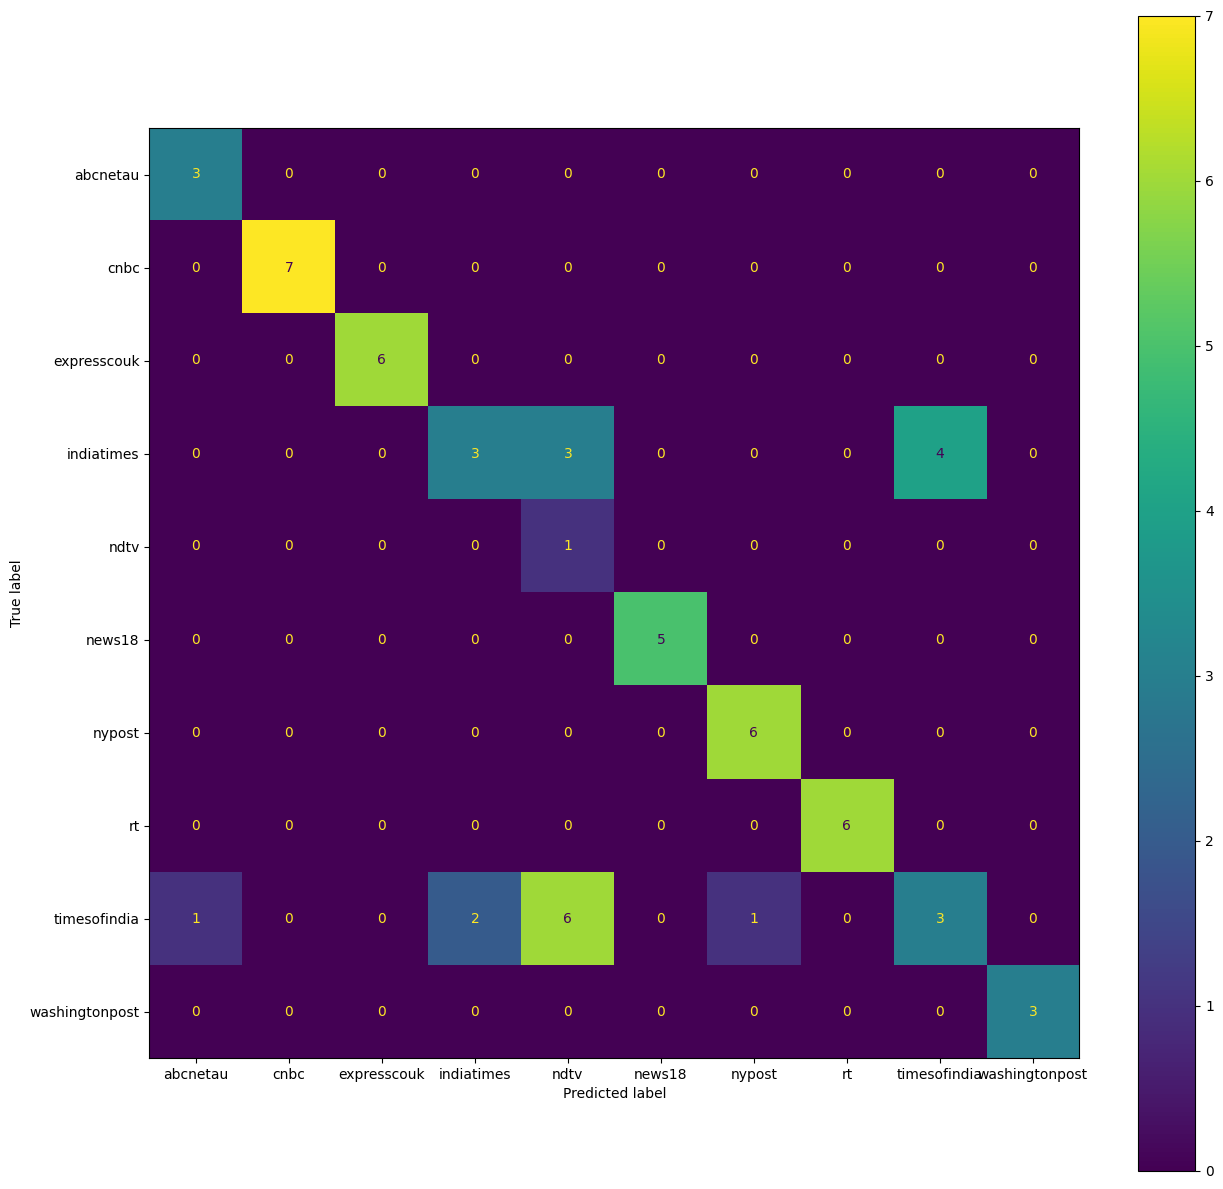

In [41]:
X = dataset.drop(['direction','sport','dport'],axis=1).dropna();
APP = X['app']
X = X.drop(['app'],axis=1)

idx = np.random.permutation(len(X))
num_train_obs = np.floor(0.7*len(X))

train_idx = idx[1:int(num_train_obs)]
test_idx = idx[int(num_train_obs):]

# normalization
X_norm = pd.DataFrame()
for key in X:
  temp = X[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X_norm[key] = temp_norm

# split train / test
X_norm_train = X_norm.iloc[train_idx]
X_norm_test = X_norm.iloc[test_idx]

APP_train = APP.iloc[train_idx]
APP_test = APP.iloc[test_idx]

#K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
i = 0;
accuracy = 0
K = 10
APP_test_predicted = []
for index, row in X_norm_test.iterrows():
  #test_entry = row.values.tolist()
  distances = []
  for ii, rr in X_norm_train.iterrows():
    #train_entry = rr.values.tolist()
    #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
    distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

  min_idx = np.argmin(distances)

  #sorted_idx = np.argsort(distances)
  #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

  predicted_app = APP_train.iloc[min_idx]
  APP_test_predicted.append(predicted_app)
  if(APP_test.iloc[i] == predicted_app):
      accuracy = accuracy+1
  i = i+1

print(accuracy/len(APP_test))
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);
